<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_ARIMA_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis For Agritech Pest Prediction

## Model Implementation:

## **ARIMA**

In [ ]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [ ]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Load datasets
Merged_Dataset_df = pd.read_csv('/content/Final_Merged_Dataset_Cleaned.csv')

In [ ]:
# Display basic info for  datasets Final_Merged_Dataset_Cleaned
print(Merged_Dataset_df.head(), '\n')
print(Merged_Dataset_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  Day Avg_temp  \
0                13.91      13.6       14.4             97.65         22.34   
1                20.78      20.1       21.2             83.49         23.52   
2                19.03      18.7       19.5             96.87         25.67   
3                15.33      15.0       15.7             82.29         25.87   
4                15.48      15.0       16.0             87.12         26.41   

   Day Min_temp  Day Max_temp  Day Avg_Humidity  Temp_change  

In [ ]:
# Convert 'Date' column to datetime format
Merged_Dataset_df['Date'] = pd.to_datetime(Merged_Dataset_df['Date'])

# Set Date column as index
Merged_Dataset_df.set_index('Date', inplace=True)

In [ ]:
# Drop redundant columns for time series modeling
DateAgg_df = Merged_Dataset_df[['Number of Insects']].copy()

# Resample data by date (sum over locations for the same day)
DateAgg_df = DateAgg_df.resample('D').sum()

# Show the processed daily data
print(DateAgg_df.head(10))

            Number of Insects
Date                         
2024-07-05                0.0
2024-07-06                0.0
2024-07-07                0.0
2024-07-08                0.0
2024-07-09                0.0
2024-07-10                0.0
2024-07-11                0.0
2024-07-12                0.0
2024-07-13                0.0
2024-07-14                1.0


### Visualization trends

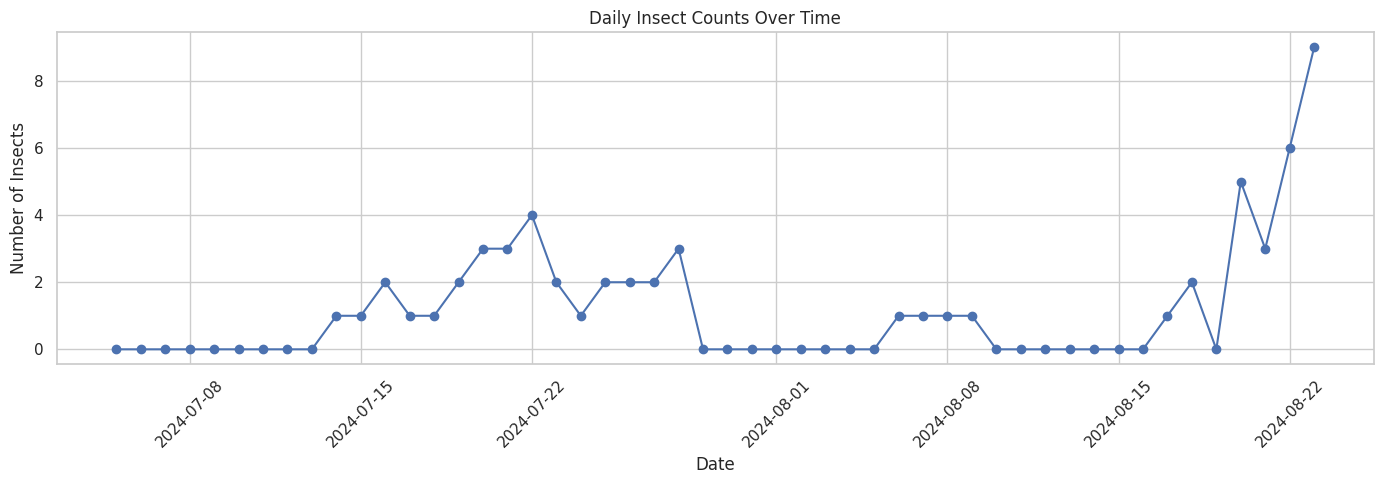

In [ ]:
##-- ### Visualization trends ### --##

# Set plot style
sns.set(style="whitegrid")

# Plot the time series
plt.figure(figsize=(14, 5))
plt.plot(DateAgg_df.index, DateAgg_df['Number of Insects'], marker='o', linestyle='-')
plt.title('Daily Insect Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

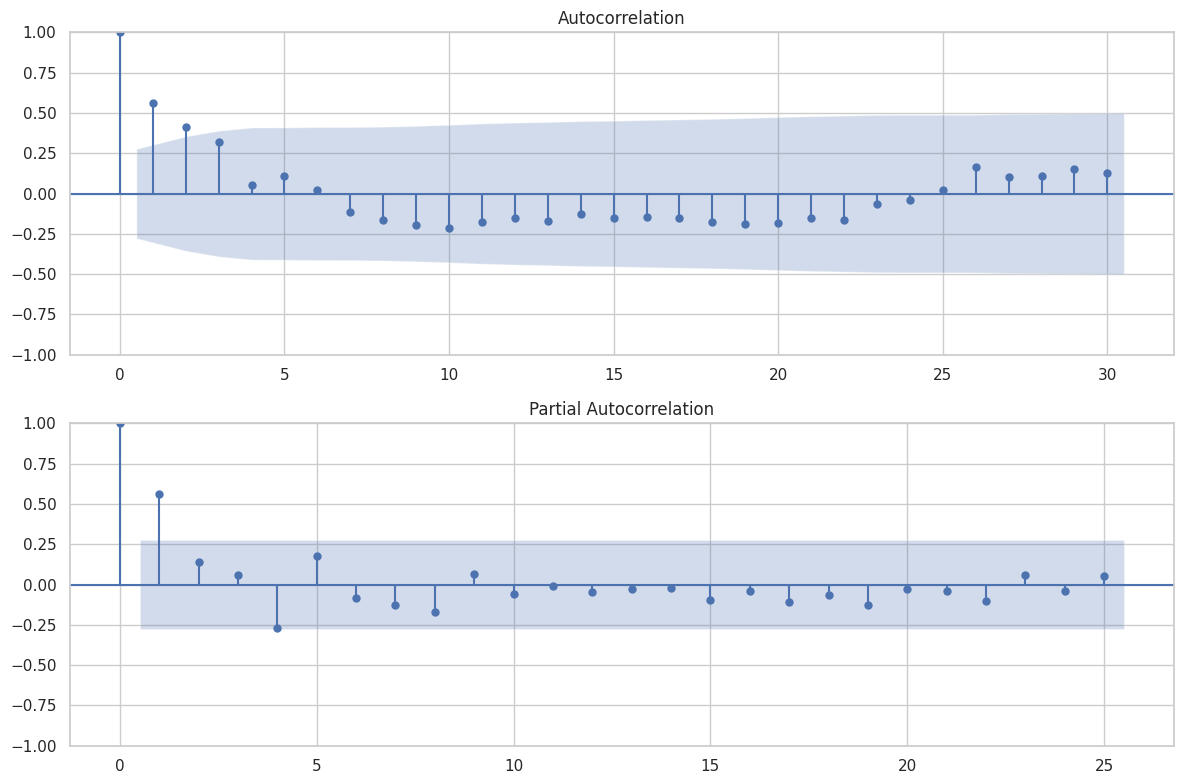

In [ ]:
# Plot ACF and PACF to examine autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(DateAgg_df['Number of Insects'], lags=30, ax=ax[0])
plot_pacf(DateAgg_df['Number of Insects'], lags=25, ax=ax[1])
plt.tight_layout()
plt.show()

### Check for Stationarity (ADF Test)

In [ ]:
# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
def check_stationarity(series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check for stationarity.

    Parameters:
        series (pd.Series): Time series data (e.g., insect count indexed by date).

    Returns:
        dict: Contains ADF statistic, p-value, critical values, and interpretation.
    """
    adf_result = adfuller(series.dropna())

    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "Critical Values": adf_result[4]
    }

    # Interpretation
    result["Stationary"] = adf_result[1] < 0.05

    print("ADF Statistic:", result["ADF Statistic"])
    print("p-value:", result["p-value"])
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")

    if result["Stationary"]:
        print("✅ Series is stationary (p < 0.05)")
    else:
        print("⚠️ Series is not stationary (p >= 0.05)")

    #return result

check_stationarity(DateAgg_df['Number of Insects'])

ADF Statistic: -1.7530607202128317
p-value: 0.4040019312158851
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895
⚠️ Series is not stationary (p >= 0.05)


### Apply Differencing (if needed) and check Stationarity

In [ ]:
# Function to apply Differencing and check Stationarity
def make_stationary(ts, max_diff=4):
    d = 0
    result = adfuller(ts.dropna())
    print(f"ADF Test p-value (d={d}): {result[1]:.4f}")

    while result[1] > 0.05 and d < max_diff:
        ts = ts.diff().dropna()
        d += 1
        result = adfuller(ts)
        print(f"ADF Test p-value (d={d}): {result[1]:.4f}")

    return ts, d

# Apply to your data
df_diff, num_diffs = make_stationary(DateAgg_df['Number of Insects'])

ADF Test p-value (d=0): 0.4040
ADF Test p-value (d=1): 0.8930
ADF Test p-value (d=2): 0.1556
ADF Test p-value (d=3): 0.0000


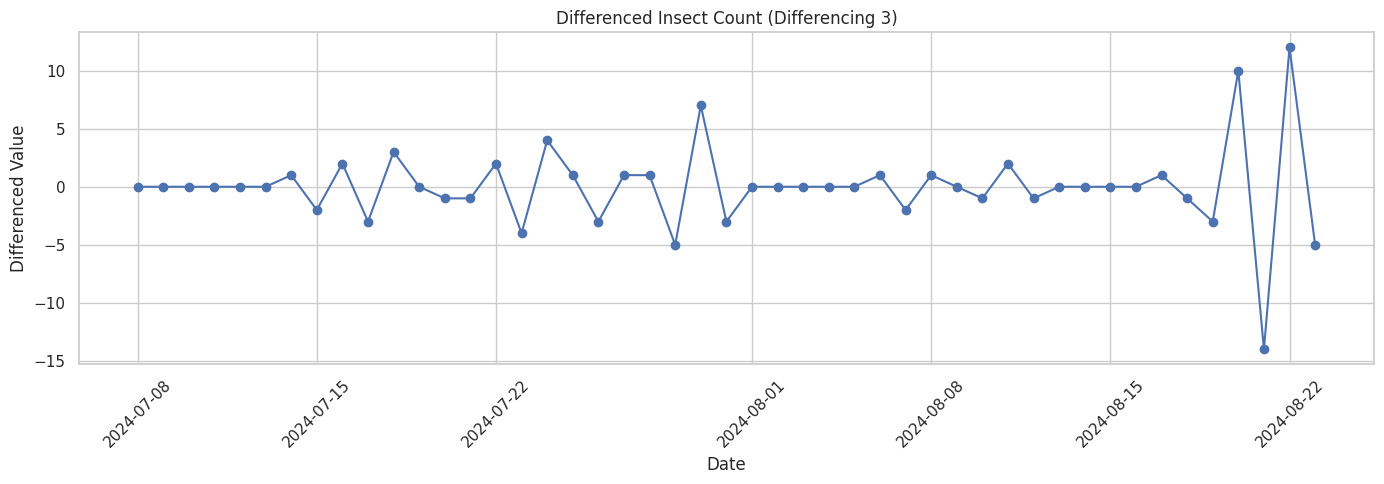

In [ ]:
# Plot differenced data
plt.figure(figsize=(14, 5))
plt.plot(df_diff, marker='o', linestyle='-')
plt.title(f'Differenced Insect Count (Differencing {num_diffs})')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Fit ARIMA with auto_arima

In [ ]:
# Implement ARIMA model with autoarima
model = auto_arima(DateAgg_df['Number of Insects'],
                   d=num_diffs,
                   seasonal=False,
                   stepwise=True,
                   trace=True,
                   suppress_warnings=True)

print(model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=164.136, Time=0.24 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=258.696, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=212.523, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,3,2)(0,0,0)[0]             : AIC=163.137, Time=0.11 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=170.995, Time=0.07 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,3,3)(0,0,0)[0]             : AIC=164.150, Time=0.19 sec
 ARIMA(0,3,3)(0,0,0)[0]             : AIC=162.589, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,3,4)(0,0,0)[0]             : AIC=inf, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,3,4)(0,0,0)[0]             : AIC=inf, Time=0.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,3,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,3,3)(0,0,0)[0]          
Total fit time: 1.875 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(0, 3, 3)   Log Likelihood                 -77.294
Date:                Sat, 05 Apr 2025   AIC                            162.589
Time:                        13:04:01   BIC                            169.990
Sample:                    07-05-2024   HQIC                           165.374
                         - 08-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.2479      0.134    -16.805      0.000      -2.510      

### Forecast Future Insect Counts

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


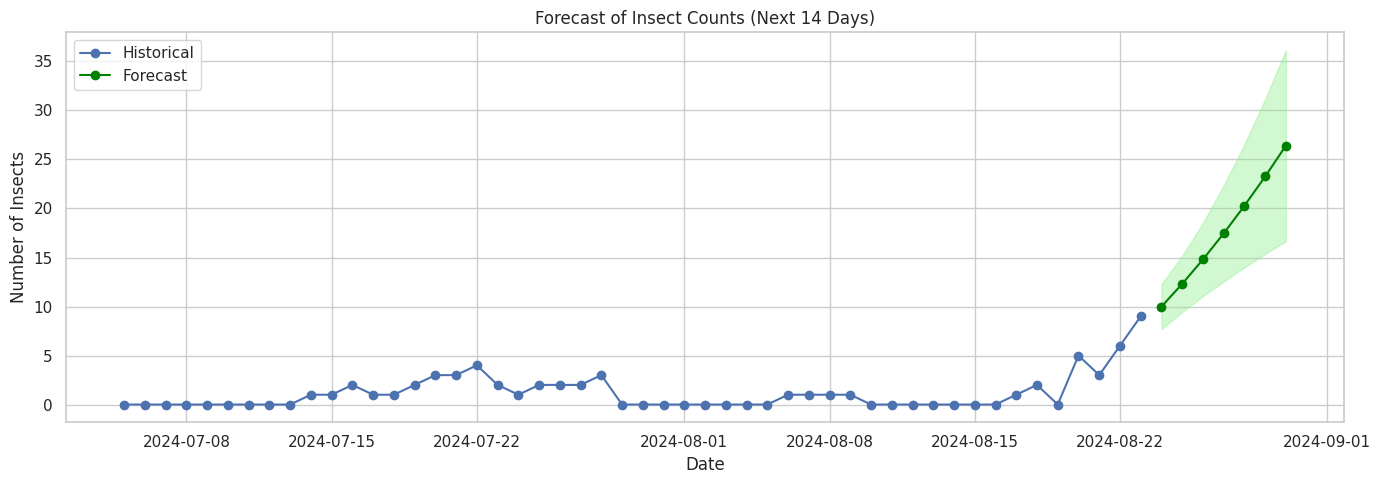

In [ ]:
# Predicting number of insects for a specific time period
n_periods = 7
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(start=DateAgg_df.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')

# Convert to DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}, index=forecast_index)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(DateAgg_df.index, DateAgg_df['Number of Insects'], label='Historical', marker='o')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='lightgreen', alpha=0.4)
plt.title('Forecast of Insect Counts (Next 14 Days)')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## ARIMA model performance
#### Train vs. Fitted Plot
This shows how closely the model’s fitted values match the actual data during training.

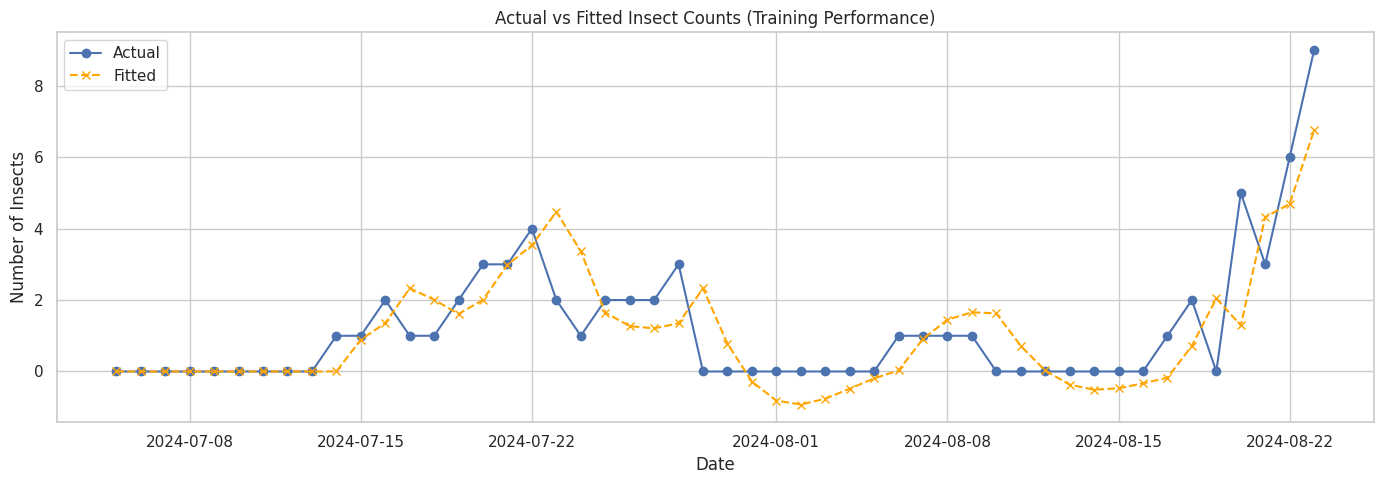

In [ ]:
# Get in-sample predictions
fitted_values = pd.Series(model.predict_in_sample(), index=DateAgg_df.index)

# Plot actual vs fitted
plt.figure(figsize=(14, 5))
plt.plot(DateAgg_df.index, DateAgg_df['Number of Insects'], label='Actual', marker='o')
plt.plot(fitted_values.index, fitted_values, label='Fitted', color='orange', linestyle='--', marker='x')
plt.title('Actual vs Fitted Insect Counts (Training Performance)')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Residual Plot (Error Over Time)
This shows the difference between actual and predicted values. Ideally, residuals should look like white noise (no pattern).

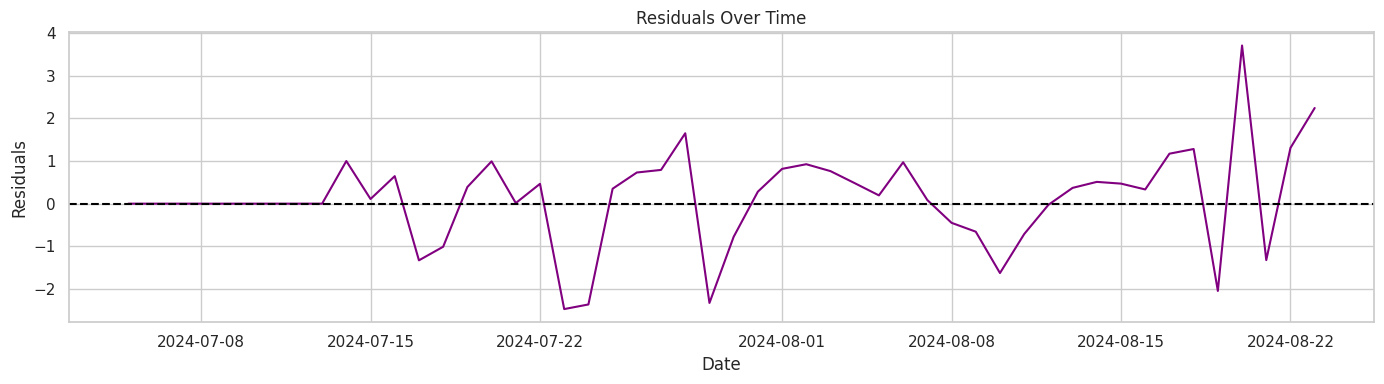

In [ ]:
# Calculate residuals
residuals = DateAgg_df['Number of Insects'] - fitted_values

# Plot residuals
plt.figure(figsize=(14, 4))
plt.plot(residuals.index, residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Histogram + Q-Q Plot of Residuals (Check Normality)
This is to check if residuals are normally distributed — a good sign for model assumptions.

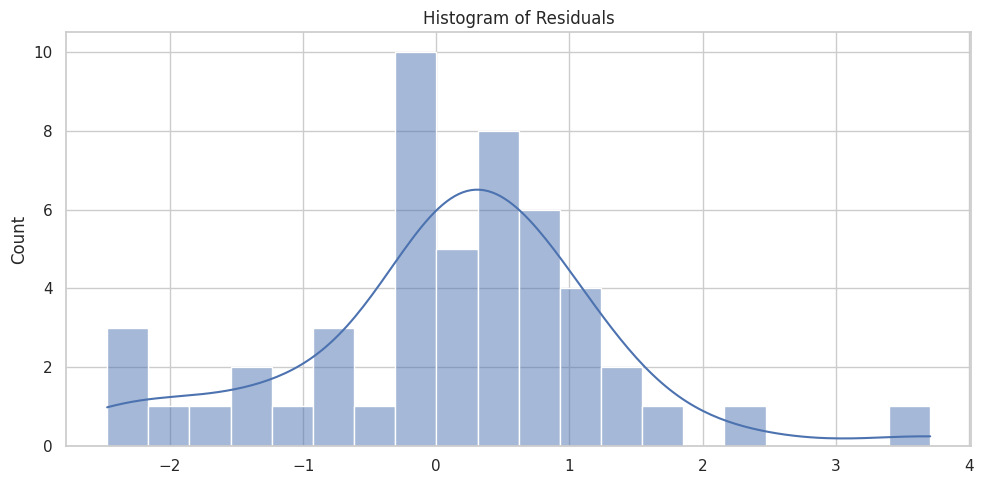

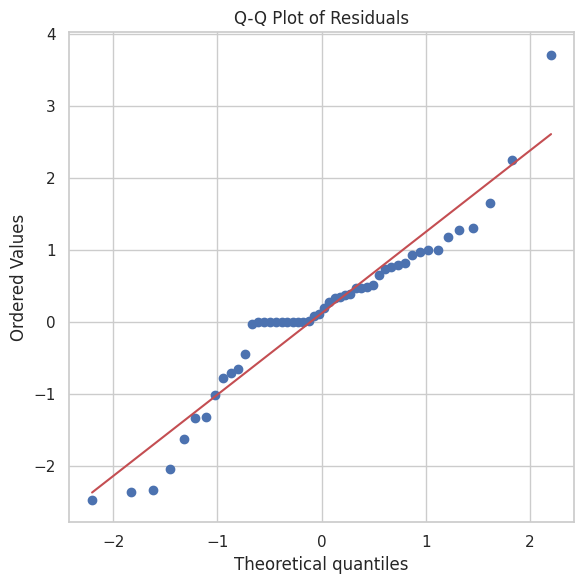

In [ ]:
import scipy.stats as stats

# Histogram of residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

print("\n")

# Q-Q Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

### Calculate Error Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual and predicted values
actual = DateAgg_df['Number of Insects']
predicted = pd.Series(model.predict_in_sample(), index=DateAgg_df.index)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, predicted)

# Root Mean Squared Error (RMSE)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual - predicted) / actual.replace(0, np.nan))) * 100

# Print results
print(f"📊 Model Performance Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

📊 Model Performance Metrics:
MAE  = 0.8038
RMSE = 1.1376
MAPE = 60.53%
